# 0. Notes:

This notebook shows how to identify vessels transiting in Bab-el mandeb Strait during the Houthi attack.

Connect to the UN Global Platform and use kernel `pyspark3.5 ais2.9`

# 1. Initialize

In [1]:
import geopandas as gpd
from shapely.geometry import mapping, Polygon

from pyspark.sql import functions as F
from pyspark.sql import Window as W
from ais import functions as af
import h3.api.numpy_int as h3int

import matplotlib.pyplot as plt

generated new fontManager


In [2]:
from sedona.spark import *

sedona = SedonaContext.create(spark)

Skipping SedonaKepler import, verify if keplergl is installed
Skipping SedonaPyDeck import, verify if pydeck is installed


In [3]:
import requests
import base64
import os
import pandas as pd
from io import StringIO

In [4]:
passageway = "bab_elmandeb_strait"
raw_ais_save_path = os.environ["USER_TEMP_S3PATH"] + f"cherryl/ais_passageways/{passageway}/ais/"

# 2. Geometries

In [5]:
request = requests.get(f"https://api.github.com/repos/cherrylchico/ais_passageways/contents/data/{passageway}.geojson")
gdf = gpd.read_file(base64.b64decode(request.json()['content']).decode('utf-8'))
gdf

,POI,Label,geometry
0,South,South Entrance,"POLYGON ((44.40252 12.66319, 44.07058 12.61990..."
1,Middle,Middle Area,"POLYGON ((43.48196 12.82258, 43.19821 12.60829..."
2,North,North Emtrance,"POLYGON ((42.72905 13.04779, 43.22778 13.31094..."


Input polygon is too small to be filled in with hexagon of resolution: 4
Attempting to fit a hex of resolution: 5...
A hex of resolution: 5 fits the input polygon
Finding it's parent in resolution: 4
Input polygon is too small to be filled in with hexagon of resolution: 4
Attempting to fit a hex of resolution: 5...
A hex of resolution: 5 fits the input polygon
Finding it's parent in resolution: 4

H3 count:32


<Axes: >

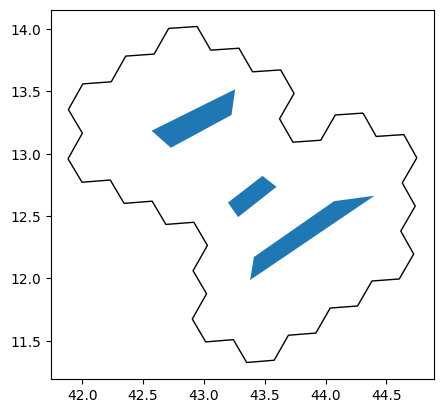

In [8]:
#We use H3 indices (https://h3geo.org/docs) as a geo-spatial filter for AIS data in the UNGP. 
#To get all AIS data within the AOIs, we overfill the geometries with H3 indices, then use the list of H3 indices as filter.  
#To ensure that the filtering is efficient, the number of H3 indices should small and the area outside of the AOI should also be small
#here, we chose H3 index resolution 6. 

h3_resolution = 4

inputs = [(row['Label'], mapping(row['geometry'])) for index, row in gdf.iterrows()]
hex_df = af.polygon_to_hex_df(inputs, h3_resolution, overfill=True)
hexes = hex_df['hex_id'].drop_duplicates().tolist()

print(f"\nH3 count:{len(hexes)}")
hexes = hex_df['hex_id'].drop_duplicates().tolist()
h3_gdf = gpd.GeoDataFrame([["H3",Polygon(h3int.h3_set_to_multi_polygon(hexes, geo_json=True)[0][0])]], columns=['h3','geometry'], crs=4326)
fig, ax = plt.subplots()
gdf.plot(ax=ax)
h3_gdf.plot(ax=ax, facecolor="none")

# 3. Extract AIS data and save to S3

## 3.1 Preparation

In [9]:
ais_cols = [
 'mmsi',
 'longitude',
 'latitude',
 'imo',
 'vessel_name',
 'vessel_type',
 'destination',
 'sog',
 'nav_status',
 'dt_pos_utc']

In [10]:
#Read Ship Register datasets as a spark dataframe, use version 20240401 which is version covering the disruption
#note that af module is from the ais package 

#The ShipData table provides information on the vessel's IMO, vessel type described by the StatCode5 and ShiptypeLevel5
ihs = af.read_ihs_table(spark, "ShipData.CSV", version="20240401") \
.select("ShipName","LRIMOShipNo","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5")

#We use the tblShipTypeCodes table to get more information on the vessel type.
#We select only "Cargo-carrying vessels" which is identified by ShiptypeLevel2 information
ihs_statcode = af.read_ihs_table(spark, "tblShipTypeCodes.CSV",  version="20240401") \
.select("StatCode5","ShiptypeLevel2") \
.filter(F.col("ShiptypeLevel2").isin(["Bulk Carriers", "Dry Cargo/Passenger", "Tankers"]))

In [12]:
#Convert geometries to spark dataframe to prepare for spark processing of geospatial data
sdf_poly = sedona.createDataFrame(gdf[['geometry','POI']])

In [13]:
def extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="overwrite"):
    #Read AIS within the start date and end date where hex ids are within the hexes list
    sdf = af.get_ais(spark, start_date=start_date, end_date=end_date, h3_list = hexes)
    
    #Get only AIS where location is within the POI geometries
    sdf_w_point = sdf.withColumn("point", F.expr("ST_Point(longitude, latitude)"))
    sdf_w_point.createOrReplaceTempView("ais_temp")
    sdf_poly.createOrReplaceTempView("poly_temp")
    sdf_poly_filter = spark.sql(""" select  * from ais_temp, poly_temp where ST_Within(point, geometry)""")
    
    #Get only AIS where the type is cargo related
    sdf_cargo = sdf_poly_filter.join(ihs.withColumnRenamed("LRIMOShipNo","imo"), how="inner", on=['imo']) \
    .join(ihs_statcode, how="inner", on=['StatCode5']) \
    .select(*ais_cols, "ShipName","MaritimeMobileServiceIdentityMMSINumber","StatCode5","ShiptypeLevel5","ShiptypeLevel2","POI") \
    .withColumns({"year":F.year("dt_pos_utc"),"month":F.month("dt_pos_utc")})
    
    #Save in S3
    sdf_cargo.write.mode(mode).partitionBy("year","month").parquet(raw_ais_save_path)
    return sdf_cargo

## 3.2 Run

In [20]:
# #Run the extraction process per month.Overwrite for the first time,and then append the next one
# start_date = "2023-11-01"
# end_date = "2023-11-30"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="overwrite")

In [21]:
# start_date = "2023-12-01"
# end_date = "2023-12-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [22]:
# start_date = "2024-01-01"
# end_date = "2024-01-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [23]:
# start_date = "2024-02-01"
# end_date = "2024-02-29"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

In [24]:
# start_date = "2024-03-01"
# end_date = "2024-03-31"
# sdf = extract_passageway_cargo(start_date, end_date, hexes, raw_ais_save_path, mode="append")

# 4. Get transits

## 4.1 Preparation

In [25]:
w = W.partitionBy("imo").orderBy("dt_pos_utc")
def get_transits(sdf, min_time_diff):
    #This function identifies the "voyages" of a vessel
    #The voyage groups together consecutive messages that likely came from a single transit through the passageway
    #A message is identified to have come from a different voyage is the time between the messages is at least a defined time period
    sdf_groups = sdf.withColumn("prev_dt_pos_utc", F.lag("dt_pos_utc").over(w)) \
    .withColumn("time_diff_hours", (F.col("dt_pos_utc").cast("long") - F.col("prev_dt_pos_utc").cast("long")) / 3600) \
    .withColumn("time_diff_flag", F.when(F.col("time_diff_hours").isNull(), 1) \
                                    .when(F.col("time_diff_hours") > min_time_diff,1) \
                                    .otherwise(0)) \
    .withColumn("voyage", F.sum("time_diff_flag").over(w)) \
    .withColumn("idle_hours", F.when(F.col("sog") < 1, F.col("time_diff_hours")).otherwise(0))
    
    #get important information from the voyages needed to identify transits and produce statistics
    transits_sdf = sdf_groups \
    .groupBy("imo","voyage") \
    .agg(F.first("vessel_name").alias("vessel_name"),
         F.first("StatCode5").alias("StatCode5"),
         F.first("ShiptypeLevel2").alias("ShiptypeLevel2"),
         F.first("ShiptypeLevel5").alias("ShiptypeLevel5"),
         F.min("dt_pos_utc").alias("arrival_date"),
         F.max("dt_pos_utc").alias("departure_date"),
         F.min_by("POI", "dt_pos_utc").alias("arrival_POI"),
         F.max_by("POI", "dt_pos_utc").alias("departure_POI"),
         F.countDistinct("POI").alias("count_distinct_POI"),
         F.sum("idle_hours").alias("idle_time")
        ) \
    .filter(F.col("arrival_POI")!=F.col("departure_POI")) \
    .withColumn("dwell_time",  (F.col("departure_date").cast("long") - F.col("arrival_date").cast("long")) / 3600) \
    .withColumn("direction",     F.concat(F.col("arrival_POI"), F.lit("-"), F.col("departure_POI"))) \
    .withColumn("complete_transit_flag", F.col("direction").isin(['North-South','South-North'])) 
    
    return transits_sdf

## 4.2 Run

In [26]:
#Read the extracted data from Section 3
sdf = spark.read.parquet(raw_ais_save_path)
print(f"Total AIS messages: {sdf.count():,}")
sdf.show(n=1, truncate=False, vertical =True)

Total AIS messages: 190,646
-RECORD 0---------------------------------------------------------
 mmsi                                    | 352002168              
 longitude                               | 43.326215              
 latitude                                | 12.70115               
 imo                                     | 9524463                
 vessel_name                             | SAKARYA                
 vessel_type                             | Tanker                 
 destination                             | EGSUZ                  
 sog                                     | 14.4                   
 nav_status                              | Under Way Using Engine 
 dt_pos_utc                              | 2023-11-18 23:20:13    
 ShipName                                | SAKARYA                
 MaritimeMobileServiceIdentityMMSINumber | 352002168              
 StatCode5                               | A13A2TV                
 ShiptypeLevel5                   

In [27]:
#Identify transits, using minimum time input of 8 hrs (rought estimate of transit time)
transits_df =  get_transits(sdf, 8).toPandas()
transits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7627 entries, 0 to 7626
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   imo                    7627 non-null   int32         
 1   voyage                 7627 non-null   int64         
 2   vessel_name            7627 non-null   object        
 3   StatCode5              7627 non-null   object        
 4   ShiptypeLevel2         7627 non-null   object        
 5   ShiptypeLevel5         7627 non-null   object        
 6   arrival_date           7627 non-null   datetime64[ns]
 7   departure_date         7627 non-null   datetime64[ns]
 8   arrival_POI            7627 non-null   object        
 9   departure_POI          7627 non-null   object        
 10  count_distinct_POI     7627 non-null   int64         
 11  idle_time              7627 non-null   float64       
 12  dwell_time             7627 non-null   float64       
 13  dir

In [28]:
#Each row of the output is a vessel transit. 
transits_df.head()

,imo,voyage,vessel_name,StatCode5,ShiptypeLevel2,ShiptypeLevel5,arrival_date,departure_date,arrival_POI,departure_POI,count_distinct_POI,idle_time,dwell_time,direction,complete_transit_flag
0,1016161,1,ZHONG PENG YOU YI,A33A2CC,Dry Cargo/Passenger,Container Ship (Fully Cellular),2023-12-29 08:24:38,2023-12-29 15:09:25,South,North,3,0.0,6.746389,South-North,True
1,1016161,2,ZHONG PENG YOU YI,A33A2CC,Dry Cargo/Passenger,Container Ship (Fully Cellular),2024-02-19 14:51:48,2024-02-19 22:21:52,North,South,3,0.0,7.501111,North-South,True
2,1016161,3,ZHONG PENG YOU YI,A33A2CC,Dry Cargo/Passenger,Container Ship (Fully Cellular),2024-03-11 05:37:02,2024-03-11 11:45:57,South,North,3,0.0,6.148611,South-North,True
3,1041116,1,ALPER 2,A31A2GX,Dry Cargo/Passenger,General Cargo Ship,2024-03-14 20:43:02,2024-03-15 06:32:03,South,North,3,0.0,9.816944,South-North,True
4,7106994,1,ALMABROUKA 11,A31A2GX,Dry Cargo/Passenger,General Cargo Ship,2024-03-05 06:29:45,2024-03-05 18:56:39,North,South,3,0.0,12.448333,North-South,True


# 5. Statistics

## 5.1 Count of Transit

In [29]:
n = transits_df[~transits_df['complete_transit_flag'] ].shape[0] / transits_df.shape[0]
print(f"""
Total Transits: {transits_df.shape[0]:,}
Complete Transits: {transits_df['complete_transit_flag'].sum():,}
Additional Transits due to Redundancy: {n*100:.2f}%
""")


Total Transits: 7,627
Complete Transits: 7,266
Additional Transits due to Redundancy: 4.73%



In [30]:
count_per_poi = transits_df.groupby("ShiptypeLevel2") \
.agg({'complete_transit_flag':'sum', 'imo':'count'}) \
.rename(columns={'complete_transit_flag':'North/South', 'imo':'North/South/Middle'})
count_per_poi['% increase'] = 100*((count_per_poi['North/South/Middle'] - count_per_poi['North/South']) / count_per_poi['North/South'])
count_per_poi

#Count of Transits According to Vessel Type and POIs captured
#Note: North/South means that the start and end POIs are both in either North or South. Thus it also contains those that passed Middle
#North/South/Middle has Middle as either start or end POIs. 

,North/South,North/South/Middle,% increase
ShiptypeLevel2,,,
Bulk Carriers,2464,2573,4.423701
Dry Cargo/Passenger,2194,2341,6.700091
Tankers,2608,2713,4.026074


## 5.2 Daily Count

In [31]:
transits_stats = transits_df \
.groupby(pd.Grouper(key="arrival_date", freq="D")) \
.agg({'imo':'count'}) \
.rename(columns={'imo':'transit_per_arrival_day'}) \
.join(transits_df[transits_df['complete_transit_flag']] \
      .groupby(pd.Grouper(key="arrival_date", freq="D")) \
      .agg({'imo':'count',
            'dwell_time':'median',
            'idle_time':'median'}) \
     .rename(columns={'imo':'complete_transit_per_arrival_day',
                      'dwell_time':'complete_transit_dwell_time',
                      'idle_time':'complete_transit_idle_time'})
     )
transits_stats

,transit_per_arrival_day,complete_transit_per_arrival_day,complete_transit_dwell_time,complete_transit_idle_time
arrival_date,,,,
2023-10-31,1,1,4.399722,0.0
2023-11-01,67,56,6.290417,0.0
2023-11-02,96,94,6.631667,0.0
2023-11-03,90,87,6.806389,0.0
2023-11-04,79,77,6.850556,0.0
...,...,...,...,...
2024-03-27,34,33,7.338889,0.0
2024-03-28,36,34,6.859861,0.0
2024-03-29,32,30,6.652500,0.0


In [33]:
#To get the outputs for  local storage
af.create_download_link(transits_stats, "Bab el-Mandeb Strait Daily Transits 202311-202403 using AIS.csv","Bab el-Mandeb Strait Daily Transits 202311-202403 using AIS.csv")